# CartPole solver using multi-agent advantage actor-critic (MAA2C) with a shared classical policy and joint classical critic.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import eqmarl
import matplotlib.pyplot as plt
import gymnasium as gym
import tensorflow.keras as keras
import tensorflow as tf

2024-01-30 11:25:52.070664: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# List any available GPUs.
tf.config.list_physical_devices('GPU')

[]

In [4]:
import numpy as np

state_bounds = tf.convert_to_tensor(np.array([2.4, 2.5, 0.21, 2.5], dtype='float32'))

def generate_model_actor_classical(n_actions: int, units: list[int], activation: str = 'relu', **kwargs) -> keras.Model:
    assert type(units) == list, 'units must be a list of integers'
    layers = []
    layers += [keras.layers.Lambda(lambda x: x/state_bounds)] # Normalizes input states.]
    layers += [keras.layers.Flatten()]
    layers += [keras.layers.Dense(u, activation=activation) for u in units]
    layers += [keras.layers.Dense(n_actions, activation='softmax', name='policy')] # Policy estimation pi(a|s)
    model = keras.Sequential(layers=layers, **kwargs)
    return model


def generate_model_critic_classical(units: list[int], activation: str = 'relu', **kwargs) -> keras.Model:
    assert type(units) == list, 'units must be a list of integers'
    layers = []
    layers += [keras.layers.Lambda(lambda x: x/state_bounds)] # Normalizes input states.]
    layers += [keras.layers.Flatten()]
    layers += [keras.layers.Dense(u, activation=activation) for u in units]
    layers += [keras.layers.Dense(1, activation=None, name='v')] # Value function estimator V(s).
    model = keras.Sequential(layers=layers, **kwargs)
    return model

In [5]:
n_actions = 2
n_agents = 2

In [6]:
# Classical actor.
model_actor = generate_model_actor_classical(
    n_actions=n_actions,
    units=[256],
    name=f"actor-classical-shared"
    )
optimizer_actor = keras.optimizers.Adam(learning_rate=3e-4)

model_actor.build((None, 4))
model_actor.summary()

Model: "actor-classical-shared"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 4)                 0         
                                                                 
 flatten (Flatten)           (None, 4)                 0         
                                                                 
 dense (Dense)               (None, 256)               1280      
                                                                 
 policy (Dense)              (None, 2)                 514       
                                                                 
Total params: 1,794
Trainable params: 1,794
Non-trainable params: 0
_________________________________________________________________


In [7]:
# Classical critic.
model_critic = generate_model_critic_classical(
    units=[256],
    name=f"critic-classical-joint"
    )
optimizer_critic = keras.optimizers.Adam(learning_rate=3e-4)

model_critic.build((None, n_agents, 4))
model_critic.summary()

Model: "critic-classical-joint"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 2, 4)              0         
                                                                 
 flatten_1 (Flatten)         (None, 8)                 0         
                                                                 
 dense_1 (Dense)             (None, 256)               2304      
                                                                 
 v (Dense)                   (None, 1)                 257       
                                                                 
Total params: 2,561
Trainable params: 2,561
Non-trainable params: 0
_________________________________________________________________


## Training

In [9]:
gamma = 0.99
alpha = 0.001
env = gym.vector.make('CartPole-v1', num_envs=n_agents)

algo = eqmarl.algorithms.MAA2C(
    env=env,
    model_actor=model_actor,
    model_critic=model_critic,
    optimizer_actor=optimizer_actor,
    optimizer_critic=optimizer_critic,
    gamma=gamma,
    alpha=alpha,
    )

reward_history, metrics_history = algo.train(n_episodes=3000, max_steps_per_episode=500)

Training for 3000 episodes, press 'Ctrl+C' to terminate early


Episode 3000: 100%|██████████| 3000/3000 [13:27<00:00,  3.72episode/s, episode_reward=[184. 184.]]


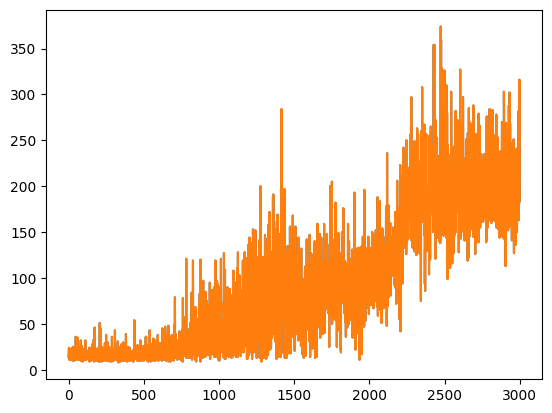

In [11]:
plt.plot(reward_history)